In [2]:
import pandas, numpy, numba
import matplotlib.pyplot as plt

# Funtions Definitions

Correct data assuming an offset and a non linearity of second order. 

Chi_sqr returns the accumulated sum of the residuals normalized or not.

In [89]:
def correct_data (x, offset, nl):
    nla = (1- nl) *4095-4095/(4095-offset)**2
    return (1- numpy.sqrt(1-4* nla * (x - offset))) / (2* nla)

def chi_sqr(residuals, data):
    return numpy.sum(numpy.power(residuals,2)/(data - residuals))

@numba.jit
def srow_nchi_sqr(residual, data):
    result = numpy.empty(32, dtype="float64")
    for i in range(32):
        result[i] = residual[i]**2 / (data[i] - residual[i])
    return numpy.sum(result)

def nchi_sqr(df, n= 3216):
    residuals = df.loc['r00':'r31'].to_numpy()
    data = df.loc['d00':'d31'].to_numpy()
    result = numpy.empty(n, dtype="float64")
    for i in range(n):
        result[i] = srow_nchi_sqr(residuals, data)
    return pandas.Series(result, name="result")

def red_chi_sqr(chi_sqr):
    return chi_sqr / (32 - 6)


Standardize data and save it for later fitting.

In [4]:
def min_max(df):
    return (df-df.min())/(df.max()-df.min())

def z_score(df):
    return (df-df.mean())/df.std()


Load the file for correction. All files must be fitted with the same parameters:

fit_data -pa 2 4 40 1.5 50 0.2 5 -b 4,2 15,0 6000,50 2.5,0.5 80,0 0.6,0 15,4 -v False True True True True True True --output -m differential_evolution

# Load file and apply functions normalization

In [5]:
to_norm = pandas.read_csv("non_linearity/c-31-23-de.csv", delimiter=',')

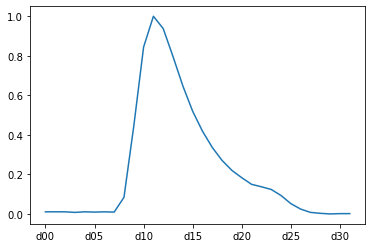

In [6]:
to_norm.loc[:,'d00':'d31'] = to_norm.loc[:,'d00':'d31'].apply(min_max, axis= 1)
if not to_norm.isnull().values.any():
    to_norm.loc[153,'d00':'d31'].plot()
    to_norm.loc[:,~to_norm.columns.isin(['N','t0','amp','tau','offset','k','dt','bic','chisqr'])].to_csv('norm-2.csv', index= False)
else:
    print('Failure at normalization.')

## Load Fitter normalized data

-0.8604962610909467

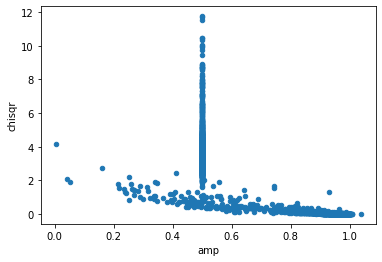

In [7]:
fit_norm = pandas.read_csv("non_linearity/fit-norm.csv", delimiter=',')
fit_norm.plot.scatter(x= 'amp',y = 'chisqr')
fit_norm.loc[:,'amp'].corr(fit_norm.loc[:,'chisqr'])

## Filter by parameter

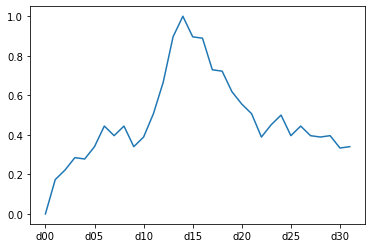

In [8]:
fit_norm.loc[fit_norm['chisqr'] > 5].loc[0,'d00':'d31'].plot()

## Scatter plot of not normalized Amplitude with Bic of normalized data

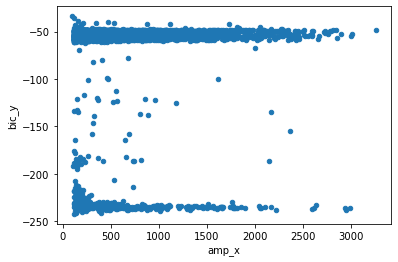

In [9]:
pandas.merge(to_norm.loc[:,'Spill':'d00'],fit_norm.loc[:,'Spill':'d00'], left_on=['Spill', 'Event'], right_on=['Spill', 'Event']).plot.scatter(x= 'amp_x',y = 'bic_y')

# Data Correction

The correct_data function takes the series and the non-linearity attenuation factor. It must be noted that it is applied as a fraction of the whole scale. The corrected data is saved in a file named "corrected-<attenuation factor>.csv" for later analysis.

0.3161111586101657


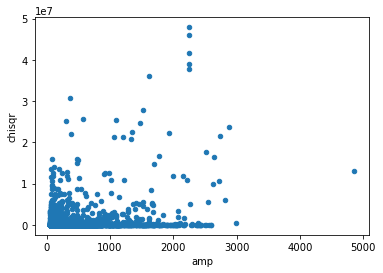

In [10]:
to_corr = pandas.read_csv("non_linearity/fit_31-23-2.csv", delimiter=',')
to_corr.plot.scatter(x= 'amp',y = 'chisqr')
print(to_corr.loc[:,'amp'].corr(to_corr.loc[:,'chisqr']))
non_linearity_attenuation_at_full_scale = 0.45
to_corr.loc[:,'d00':'d31'] = to_corr.loc[:,'d00':'d31'].apply(correct_data, args= (non_linearity_attenuation_at_full_scale, 50), axis= 1)
if not to_corr.isnull().values.any():
    to_corr.loc[:,~to_corr.columns.isin(['N','t0','amp','tau','offset','k','dt','bic','chisqr'])].to_csv('corrected-{}-2.csv'.format(non_linearity_attenuation_at_full_scale), index= False)
else:
    print('Invalid nla value: {}'.format(non_linearity_attenuation_at_full_scale))

# Non-linearity test No.1
Load the fit of the corrected data and plot the amplitude vs bic to visualize the impact of the correction on the goodness of the model.

1. Fit selected data, preferibly only semi-Gaussian pulses.
2. Normalize the data
3. Fit the normalized data
4. Plot the bic from the normalized fit against the amplitude of the original data

## Issues

* Normalize pulses do not necessarly yield normalized bic
* Normalize data has different SNR making noise impact bigger for smaller pulses and impossible to remove from the bic

In [11]:
fit_corr = pandas.read_csv("non_linearity/fit_corrected-0.05.csv", delimiter=',')
fit_corr.plot.scatter(x= 'amp',y = 'bic')
fit_corr.loc[:,'amp'].corr(fit_corr.loc[:,'bic'])

FileNotFoundError: [Errno 2] No such file or directory: 'non_linearity/fit_corrected-0.05.csv'

# Non linearity test No.2

1. Fit non-normalized pulses
2. Take the smallest and biggest amplitude
3. Compare the normalized residuals
4. Calculate Chi-square with normalized residuals

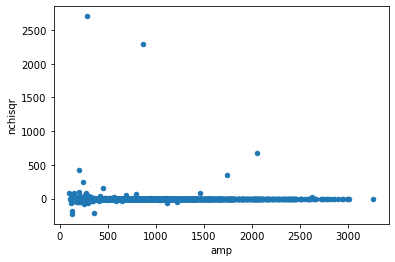

In [91]:
to_norm['nchisqr'] = to_norm.apply(nchi_sqr, axis=1)
to_norm.plot.scatter(x= 'amp',y = 'nchisqr')

# Comparisson of residuals of big and small pulses

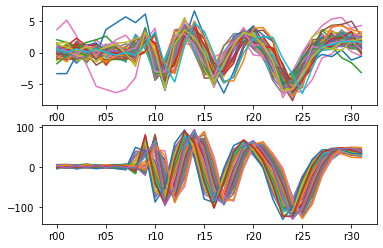

In [18]:
ord_by_amp = to_norm.sort_values(by=['amp'])
fig, ax = plt.subplots(2)
ord_by_amp.loc[:,'r00':'r31'].iloc[5:55,:].T.plot(ax=ax[0], legend= False)
ord_by_amp.loc[:,'r00':'r31'].iloc[-56:-1,:].T.plot(ax=ax[1], legend= False)

0.008475254421835512

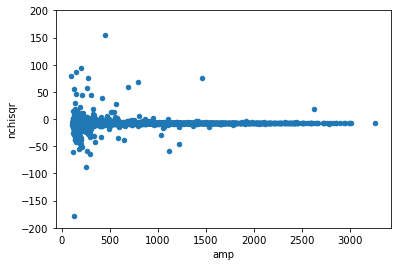

In [99]:
to_norm.plot.scatter(x= 'amp',y = 'nchisqr', ylim=(-200,200))
to_norm.loc[:,'amp'].corr(to_norm.loc[:,'nchisqr'])